In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

In [2]:
# table.to_pickle("Day1")
# table = pd.read_pickle("./data/Day1")
# table.to_pickle("./dataUpdatedDay1")

In [3]:
table = pd.read_json("data/combined_day1", lines=True, chunksize=100000)

In [4]:
table = pd.concat(table)

In [115]:
# Load in data from HDF file, which is faster
df_store = pd.HDFStore('data/combined_day1_processed.h5')
pos_store = pd.HDFStore('data/positives_processed.h5')
positives = pos_store['df'] 
day1 = df_store['df']

In [123]:
combined = pd.concat([positives, day1])

## Data Exploration

### New Data

In [127]:
combined.shape

(1578362, 46)

In [131]:
# Number of clicks and non-click to click ratio in data
CLICKED_CNT = combined.c_cnt.value_counts()[1]
NONCLICK_RATIO = int(combined.c_cnt.value_counts()[0] / combined.c_cnt.value_counts()[1])
CLICKED_CNT, NONCLICK_RATIO

(9092, 172)

In [148]:
click_rates = score_advertisers(combined, lambda x: x).reset_index()
# Add ctr rate column to the table
click_rates.rename(columns={"c_cnt": "ctr_rate"}, inplace=True)
combined = pd.merge(combined, click_rates, on="advertiser_id")

In [178]:
url_domains = combined["url"].str.extract('^(?:https?:\/\/)?(?:[^@\/\n]+@)?(?:www\.)?([^:\/\n]+)')
combined["domain"] = url_domains.astype(str)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


### Old Data

In [118]:
table.shape

(2262922, 75)

In [159]:
table.head()

,_host,ad_network_id,ad_type,adlog_count,advertiser_id,bid_requests,bid_responses,c_cnt,c_flag_cnt,c_timestamp,...,ua_os_name,url,user_agent,uuid,vi_cnt,vi_flag_cnt,vi_timestamp,vv_cnt,widget_id,zone_id
0,an-prod-ralphie-frontline-bulks.us-east-1,1349,[story],1,3587,[],[],0.0,0.0,NaN,...,iOS,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (iPad; CPU OS 10_3_3 like Mac OS X...,60039c05-5285-49ca-b4eb-a435e9d8352b,0.0,0.0,NaN,0.0,NaN,26024
1,an-prod-ralphie-frontline-bedim.us-east-1,1349,[story],1,3587,[],[],0.0,0.0,NaN,...,iOS,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (iPad; CPU OS 11_2_6 like Mac OS X...,504e4902-4a71-4155-9de8-32e4afc00013,0.0,0.0,NaN,0.0,NaN,26024
2,an-prod-ralphie-frontline-bedim.us-east-1,767,[story],1,4735,[],[],0.0,0.0,NaN,...,iOS,http://thehill.com/policy/national-security/38...,Mozilla/5.0 (iPad; CPU OS 11_2_6 like Mac OS X...,c182f217-aff0-4f43-b74c-8c19344efbbf,1.0,0.0,2018-04-01T00:39:06.102000Z,0.0,NaN,18310
3,an-prod-ralphie-frontline-goofs.us-east-1,727,[story],1,4909,[],[],NaN,NaN,NaN,...,Android,http://getpocket.com,NaN,429TaA7bgeWM3pk04ed1783dc1p4g4e349bc6flc28o91b...,NaN,NaN,NaN,NaN,NaN,14414
4,an-prod-ralphie-frontline-soths.us-east-1,1349,[story],1,3587,[],[],0.0,0.0,NaN,...,Android,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (Linux; Android 7.0; SAMSUNG SM-T8...,1a95be28-1ffe-4e21-8c1f-3e3838c61526,0.0,0.0,NaN,0.0,NaN,26024


In [5]:
# Remove rows with null c_cnt, i_timestamp and ua_device type values
filtered = table[(~np.isnan(table["c_cnt"]))]
filtered.dropna(subset=["i_timestamp", "ua_device_type"], inplace=True)
filtered.shape

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(1703754, 75)

In [210]:
filtered.columns

Index(['_host', 'ad_network_id', 'ad_type', 'adlog_count', 'advertiser_id',
       'bid_requests', 'bid_responses', 'c_cnt', 'c_flag_cnt', 'c_timestamp',
       'c_txn_fee', 'c_txn_rate', 'campaign_id', 'campaign_type', 'ck',
       'cr_cnt', 'creative_id', 'exp_mode', 'f_cnt', 'f_nfr', 'f_timestamp',
       'flag', 'geo_area_code', 'geo_city_code', 'geo_city_name',
       'geo_continent_code', 'geo_country_code2', 'geo_country_code3',
       'geo_dma_code', 'geo_postal_code', 'geo_region_name', 'geo_timezone',
       'i_cnt', 'i_flag_cnt', 'i_timestamp', 'i_txn_fee', 'i_txn_rate',
       'ip_address', 'is_bot', 'is_fraud', 'keywords', 'num_ads', 'preview',
       'pub_campaign_id', 'pub_network_id', 'r_cnt', 'r_num_ads_requested',
       'r_num_ads_returned', 'r_num_ads_third_party', 'r_timestamp',
       'rate_metric', 'referer', 'session_id', 'site_id', 'tag_value', 'token',
       'txn_fee', 'txn_rate', 'ua', 'ua_device', 'ua_device_type', 'ua_major',
       'ua_minor', 'ua_name', 

### Browser

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


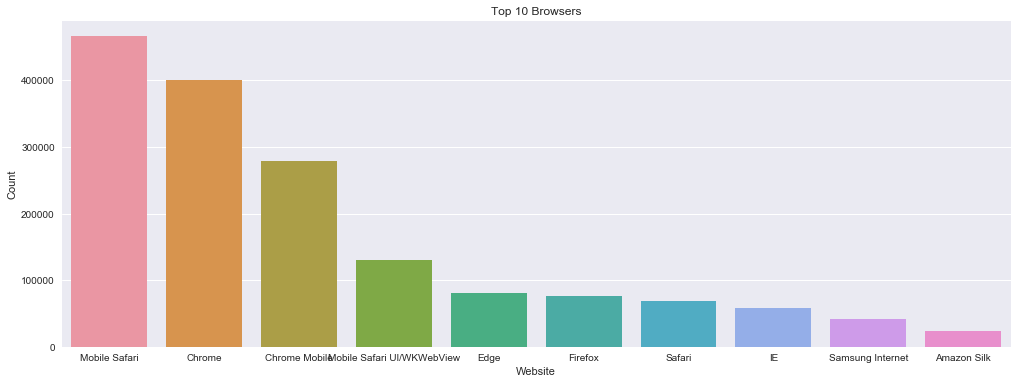

In [333]:
top_10_browsers = filtered["ua_name"].value_counts()[:10]
fig, ax = plt.subplots()
fig.set_size_inches(17, 6)
ax.set(xlabel='Website', ylabel='Count', title='Top 10 Browsers')
sns.barplot(ax=ax, x=top_10_browsers.index.values, y=top_10_browsers.values)
plt.show()

In [350]:
top_10_browsers_table = filtered[filtered["ua_name"].isin(top_10_browsers.index)]

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


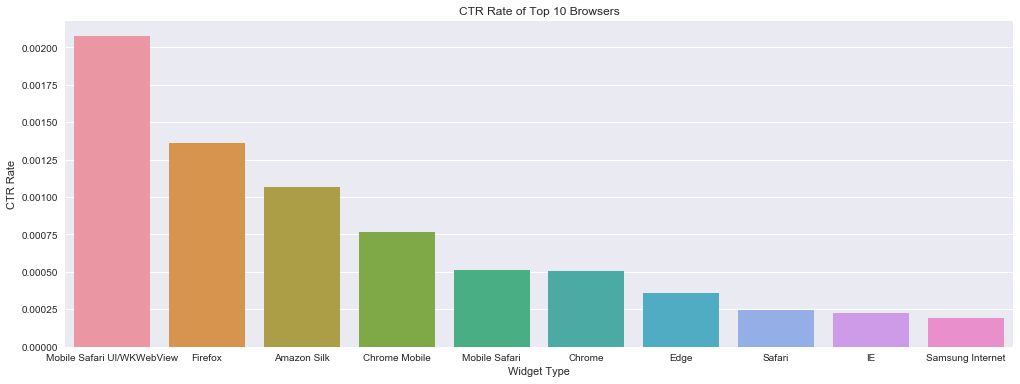

In [357]:
browser_ctr_rate = (top_10_browsers_table[["ua_name", "c_cnt"]].groupby("ua_name").sum() / 
                   top_10_browsers_table[["ua_name", "c_cnt"]].groupby("ua_name").count())
browser_ctr_rate.sort_values(by="c_cnt", inplace=True, ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(17, 6)
sns.barplot(x=browser_ctr_rate.index.values, y=browser_ctr_rate.c_cnt.values)
ax.set(xlabel='Widget Type', ylabel='CTR Rate', title='CTR Rate of Top 10 Browsers')
plt.show()

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


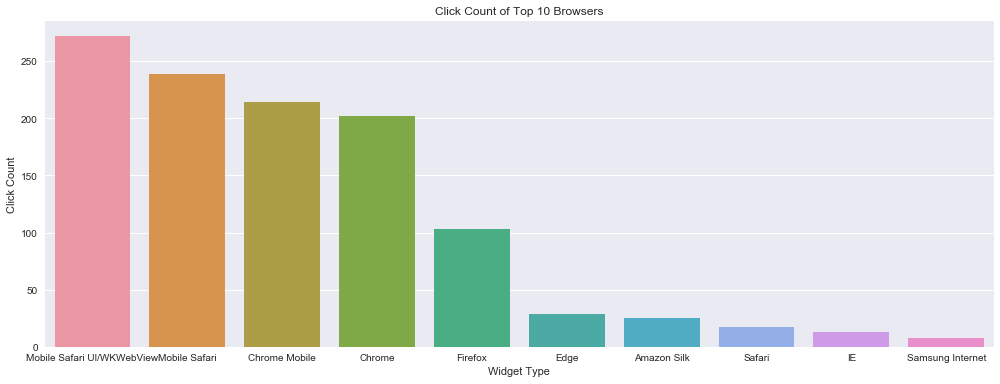

In [362]:
click_count_browsers = top_10_browsers_table[["ua_name", "c_cnt"]].groupby("ua_name").sum()
click_count_browsers.sort_values(by="c_cnt", inplace=True, ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(17, 6)
sns.barplot(x=click_count_browsers.index.values, y=click_count_browsers.c_cnt.values)
ax.set(xlabel='Widget Type', ylabel='Click Count', title='Click Count of Top 10 Browsers')
plt.show()

### Domain

In [259]:
# Extract domains from urls
url_domains = filtered["url"].str.extract('^(?:https?:\/\/)?(?:[^@\/\n]+@)?(?:www\.)?([^:\/\n]+)')
filtered["domain"] = url_domains

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


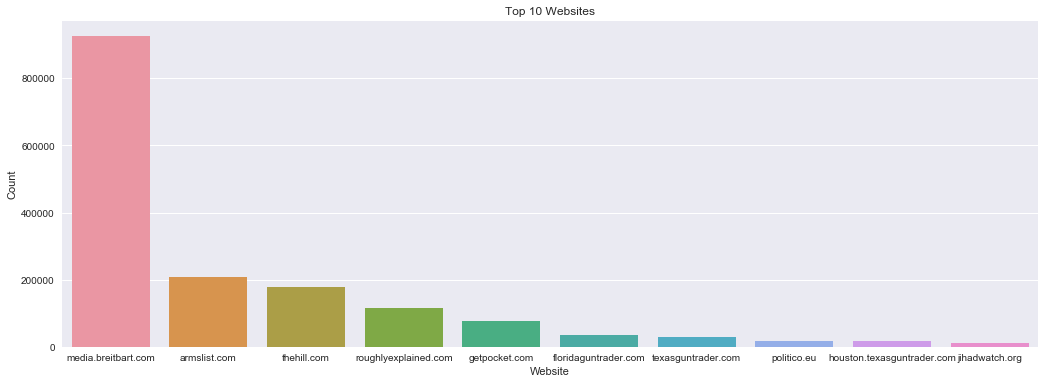

In [286]:
top_10_domains = url_domains.value_counts()[:10]

fig, ax = plt.subplots()
fig.set_size_inches(17.5, 6)
ax.set(xlabel='Website', ylabel='Count', title='Top 10 Websites')
sns.barplot(ax=ax, x=top_10_domains.index.values, y=top_10_domains.values)
plt.show()

### Widget

In [274]:
widget_type = filtered["ck"].str.extract('\["(.*?)\"]')
filtered["widget_type"] = widget_type
widget_type.value_counts()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


text_feed           1165837
image                114051
content_feed             13
article_instream          6
                          5
video                     1
Name: ck, dtype: int64

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


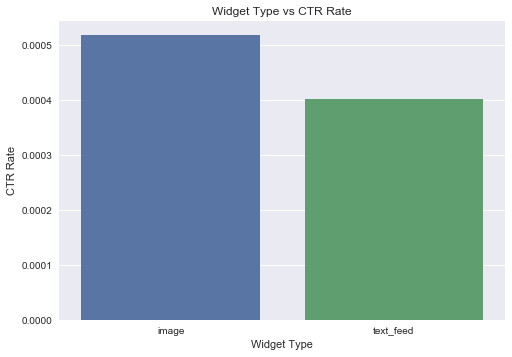

In [285]:
# CTR rate for each widget type
widget_ctr_rate = (filtered[["widget_type", "c_cnt"]].groupby("widget_type").sum() / 
                   filtered[["widget_type", "c_cnt"]].groupby("widget_type").count())
image_textfeed = widget_ctr_rate.loc[["image", "text_feed"]]
ax = sns.barplot(x=image_textfeed.index.values, y=image_textfeed.c_cnt.values)
ax.set(xlabel='Widget Type', ylabel='CTR Rate', title='Widget Type vs CTR Rate')
plt.show()

In [18]:
# Number of clicks and non-click to click ratio in data
CLICKED_CNT = filtered.c_cnt.value_counts()[1]
NONCLICK_RATIO = int(filtered.c_cnt.value_counts()[0] / filtered.c_cnt.value_counts()[1])
CLICKED_CNT, NONCLICK_RATIO

(1167, 1458)

In [6]:
# Find average ctr rate of each advertiser
def score_advertisers(table, score_func):
    click_counts = table[["advertiser_id", "c_cnt"]]
    clean_ccnt = click_counts.dropna()
    grouped = clean_ccnt.groupby("advertiser_id")
    score_means = lambda x: score_func(np.mean(x))
    agg_scored = grouped.agg({'c_cnt': score_means})
    return agg_scored

click_rates = score_advertisers(filtered, lambda x: x).reset_index()

In [7]:
# Add ctr rate column to the table
click_rates.rename(columns={"c_cnt": "ctr_rate"}, inplace=True)
filtered = pd.merge(filtered, click_rates, on="advertiser_id")
filtered.head()

,_host,ad_network_id,ad_type,adlog_count,advertiser_id,bid_requests,bid_responses,c_cnt,c_flag_cnt,c_timestamp,...,url,user_agent,uuid,vi_cnt,vi_flag_cnt,vi_timestamp,vv_cnt,widget_id,zone_id,ctr_rate
0,an-prod-ralphie-frontline-bulks.us-east-1,1349,[story],1,3587,[],[],0.0,0.0,NaN,...,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (iPad; CPU OS 10_3_3 like Mac OS X...,60039c05-5285-49ca-b4eb-a435e9d8352b,0.0,0.0,NaN,0.0,NaN,26024,0.00109
1,an-prod-ralphie-frontline-bedim.us-east-1,1349,[story],1,3587,[],[],0.0,0.0,NaN,...,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (iPad; CPU OS 11_2_6 like Mac OS X...,504e4902-4a71-4155-9de8-32e4afc00013,0.0,0.0,NaN,0.0,NaN,26024,0.00109
2,an-prod-ralphie-frontline-soths.us-east-1,1349,[story],1,3587,[],[],0.0,0.0,NaN,...,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (Linux; Android 7.0; SAMSUNG SM-T8...,1a95be28-1ffe-4e21-8c1f-3e3838c61526,0.0,0.0,NaN,0.0,NaN,26024,0.00109
3,an-prod-ralphie-frontline-soths.us-east-1,1349,[story],1,3587,[],[],0.0,0.0,NaN,...,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (iPad; CPU OS 10_3_3 like Mac OS X...,04ae8926-eb59-433a-b515-97d7095adb0a,0.0,0.0,NaN,0.0,NaN,26024,0.00109
4,an-prod-ralphie-frontline-lamed.us-east-1,1349,[story],1,3587,[],[],0.0,0.0,NaN,...,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (iPad; CPU OS 11_2_6 like Mac OS X...,1cd0710d-3584-4453-b9ed-458b4e2a6018,0.0,0.0,NaN,0.0,NaN,26024,0.00109


In [137]:
filtered["ua_device_type"].value_counts()

MOB    748561
PC     653074
TAB    297477
BOT      4642
Name: ua_device_type, dtype: int64

In [23]:
filtered['campaign_type'].value_counts()

private    1223053
outside     480701
Name: campaign_type, dtype: int64

## Feature Engineering and Model Creation (For Boosting)

In [8]:
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction import FeatureHasher

In [9]:
# Shuffle data
filtered = shuffle(filtered)

In [138]:
combined = shuffle(combined)

In [10]:
# Fit one hot encoder to device type and continent code features
le_device = preprocessing.LabelBinarizer()
transformed_device = le_device.fit(filtered["ua_device_type"])

le_cont = preprocessing.LabelBinarizer()
transformed_continent = le_cont.fit(filtered["geo_continent_code"])

In [239]:
def generate_sample(n, df):
    """Return X matrix with n no click samples and CLICKED_CNT click samples (undersampling)"""
    clicked = df[df["c_cnt"] == 1]
    no_click = df[df["c_cnt"] == 0].sample(n)
    return shuffle(pd.concat([clicked, no_click]))

def generate_ratio(n, ratio, df):
    """
    Returns random subset(training data) of df matrix with n/2 click samples and (n/2 * ratio) nonclicks,
    along with another random subset that contains data not included in training data(test data)
    
    """
    clicked = df[df["c_cnt"] == 1].reset_index(drop=True)
    no_click = df[df["c_cnt"] == 0].reset_index(drop=True)
    
    click_idx = np.random.randint(n, size=int(n/2))
    no_click_idx = np.random.randint(no_click.shape[0], size=int(n/2 * ratio))
    
    #click_filtered and no_click_filtered only keep rows that aren't part of training set
    click_filtered, no_click_filtered = clicked.drop(click_idx), no_click.drop(no_click_idx)
    no_click_filtered_idx = np.random.randint(no_click_filtered.shape[0], size=int(click_filtered.shape[0] * 15))
    
    train = shuffle(pd.concat([clicked.iloc[click_idx, :], no_click.iloc[no_click_idx, :]]))
    test = shuffle(pd.concat([click_filtered, no_click_filtered.iloc[no_click_filtered_idx, :]]))
    return train, test

Let's create our features:

In [204]:
def transform_hour(x):
    """Assigns hour to a bin"""
    if x >= 5 and x < 8: return 1 #early morning 
    elif x >= 8 and x < 11: return 2 #morning 
    elif x >= 11 and x < 14: return 3 #midday
    elif x >= 14 and x < 19: return 4 #afternoon
    elif x >= 19 and x < 22: return 5 #evening
    else: return 6 #night
    
def create_numerical_features(sample):
    """Returns a dataframe with the necessary numberical features from dataframe sample"""
    df = pd.DataFrame()
    df["i_cnt"] = sample["i_cnt"].tolist()
    df["r_cnt"] = sample["r_cnt"].tolist()
    df["campaign_type"] = sample["campaign_type"].apply(lambda x: 1 if x == "private" else 0).tolist()
    df["ctr_rate"] = sample["ctr_rate"].tolist()
    df["num_ads_requested"] = sample["r_num_ads_requested"].tolist()
    # Create hour feature
#     hours = sample["i_timestamp"].str[11:13] # get hour of timestamp column
    # X_data["hour"] = np.sin(hours.astype(int)).tolist() #sine transform hour because it's cyclical
#     df["hour"] = hours.astype(int).apply(transform_hour).tolist()
    df["hour"] = sample["i_timestamp"].astype(int).tolist()
    return df

def create_features(sample):
    """"Creates necessary features, returns X and y matrix"""
    X = create_numerical_features(sample)
    y = sample["c_cnt"]
    
    # Hash sparse features, allows for less sparse representation than one hot encoding
    # More info can be found on https://en.wikipedia.org/wiki/Feature_hashing
    h = FeatureHasher(n_features=30, input_type='string')
    features = [] #store all features 
    features.append(X)
    for feature in ["advertiser_id", "ad_network_id", "geo_country_code2", 
                    "ua_os_name", "site_id", "ua_name", "campaign_id", "domain"]:
        hashed = h.transform(sample[feature].astype(str)).toarray()
        features.append(pd.DataFrame(hashed))
    
    encoded_device = transformed_device.transform(sample["ua_device_type"])
#     encoded_continent = transformed_continent.transform(sample["geo_continent_code"])
    features.append(pd.DataFrame(encoded_device))
#     features.append(pd.DataFrame(encoded_continent))
    return pd.concat(features, axis=1), y #combine all features

In [39]:
def find_best_ratio(classifier):
    """Perform cross validation to determine best ratio non-click to click ratio for training data"""
    best_ratio = 1
    best_f1 = 0
    for ratio in [5, 10, 15]:
        train_sample, test_sample = generate_ratio(CLICKED_CNT, ratio, df=combined)
        X_train, y_train = create_features(train_sample)
        X_test, y_test = create_features(test_sample)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        # Use f1 score as the metric, accuracy isn't good metric because of class imbalance
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1, best_ratio = f1, ratio
    return best_f1, best_ratio

Getting a low F1 score :(

In [40]:
xgboost = ensemble.GradientBoostingClassifier() #xgboost was found to perform better than bagging and adaboost
best_f1, best_ratio = find_best_ratio(classifier=xgboost) #takes a very long time to run
print("Best F1 Score:", best_f1)
print("Best non-click to click ratio:", best_ratio)

Best F1 Score: 0.0194267515924
Best non-click to click ratio: 15


# FFM (inspired by https://www.csie.ntu.edu.tw/~cjlin/papers/ffm.pdf)

In [11]:
import xlearn as xl
xl.hello() #xl only prints in terminal

In [249]:
def generate_ratio_ffm(n, split, ratio, df):
    """
    Returns random subset(training data) of df matrix with (split) * n click samples and (split n * ratio) nonclicks,
    along with another random subset that contains test_click click samples and test_click * NONCLICK_RATIO 
    nonclicks (test data)
    """
    clicked = df[df["c_cnt"] == 1].reset_index(drop=True)
    no_click = df[df["c_cnt"] == 0].reset_index(drop=True)
    
    click_idx = np.random.randint(n, size=int(split * n))
    no_click_idx = np.random.randint(no_click.shape[0], size=int(split * n * ratio))
    
    #click_filtered and no_click_filtered only keep rows that aren't part of training set
    click_filtered, no_click_filtered = clicked.drop(click_idx), no_click.drop(no_click_idx)
    half = int(click_filtered.shape[0] / 2)
    no_click_filtered_val_idx = np.random.randint(no_click_filtered.shape[0], size=int(half * 15))
    no_click_filtered_test_idx = np.random.randint(no_click_filtered.shape[0], size=int(half * 15))
    
    train = shuffle(pd.concat([clicked.iloc[click_idx, :], no_click.iloc[no_click_idx, :]]))
    validate = shuffle(pd.concat([click_filtered[:half], no_click_filtered.iloc[no_click_filtered_val_idx, :]]))
    test = shuffle(pd.concat([click_filtered[half:], no_click_filtered.iloc[no_click_filtered_test_idx, :]]))
    return train, validate, test

We need to make a new dataframe with categorical features one-hot encoded instead of hashed:

In [15]:
encoders = {} #cache encoders

In [174]:
# Create encoders and one hot encode features
max_categories = 30 #limit one hot encoding
def encode_feature(feature, sample, df):
    """One hot encode given feature from sample matrix and return"""
    if feature not in encoders:
        encoder = preprocessing.LabelBinarizer()
        encoder.fit(df[feature].value_counts()[:max_categories]
                             .index
                             .tolist()
                    )
        encoders[feature] = encoder
    else:
        encoder = encoders[feature]
    return encoder.transform(sample[feature])

def create_numerical_features_ffm(sample):
    """Returns a dataframe with the necessary numberical features from dataframe sample"""
    df = create_numerical_features(sample)
    df = pd.concat([pd.DataFrame(sample["c_cnt"].tolist()), df], axis=1).reset_index(drop=True)
    return df

feature_count = [] # Tracks number of columns per categorical feature, i.e. device_type has 4 columns
def create_features_ffm(sample):
    """"Creates features for FFM model"""
    df = create_numerical_features_ffm(sample)
    features = [] #store all features 
    features.append(df)
    features_to_use = ["advertiser_id", "ad_network_id", "geo_country_code2", #removed geo_continent_code
                        "ua_os_name", "site_id", "ua_name", "campaign_id", "domain"]
    for feature in features_to_use:
        encoded = encode_feature(feature, sample, df=combined)
        if len(feature_count) < len(features_to_use): feature_count.append(encoded.shape[1])
        features.append(pd.DataFrame(encoded))
        
    encoded_device = transformed_device.transform(sample["ua_device_type"])
    if len(feature_count) <= len(features_to_use): feature_count.append(encoded_device.shape[1])
    features.append(pd.DataFrame(encoded_device))
    return pd.concat(features, axis=1)#combine all features


In [250]:
# Generate raw data for FFM model
train_ffm, validate_ffm, test_ffm = generate_ratio_ffm(CLICKED_CNT, split=0.6, ratio=5, df=combined)

In [254]:
# Create all features
train_ffm_transformed = create_features_ffm(train_ffm)
validate_ffm_transformed = create_features_ffm(validate_ffm)
test_ffm_transformed = create_features_ffm(test_ffm)

In [255]:
feature_count

[30, 26, 30, 29, 30, 30, 30, 30, 4]

In [37]:
# rows = 1000000
# # Inspired by https://www.analyticsvidhya.com/blog/2018/01/factorization-machines/
# def convert_to_ffm(df,data_type,numerics):
#     """Converts df to ffm format and saves it to a text file"""
#     nrows = df.shape[0]
#     ncols = df.shape[1]
#     with open("ffm/" + str(data_type) + "_ffm.txt", "w") as text_file:
#         # Looping over rows to convert each row to libffm format
#         datastring = ""
#         for r in range(nrows)[:rows]: #first 1,000,000 rows for now
#             datarow = df.iloc[r].to_dict()
#             datastring += str(int(datarow['c_cnt']))
#             field_position = 0
#             feature_count_index = 0
#             for i in range(1, ncols):
#                 if field_position == feature_count[feature_count_index]:
#                     feature_count_index += 1
#                     field_position = 0
#                 # For numerical fields, we are creating a dummy field here
#                 if (i - 1) < len(numerics):
#                     #we are dealing with a numeric feature
#                     feat = numerics[i - 1]
#                     datastring = datastring + " "+str(i)+":"+ str(i)+":"+ str(datarow[feat])
#                 else:
#                     #categorical feature
#                     if datarow[i] == 1:
#                         datastring = datastring + " "+str(feature_count_index + 7)+":"+ str(field_position)+":1"
#                     field_position += 1
#             datastring += '\n'
#         text_file.write(datastring)

In [256]:
# Generate list of numeric feature names
numerics = train_ffm_transformed.columns[1:7].tolist()
numerics

['i_cnt', 'r_cnt', 'campaign_type', 'ctr_rate', 'num_ads_requested', 'hour']

In [264]:
# Rename columns to make it easier to transform to libffm format
ncolumns = train_ffm_transformed.columns.shape[0]
train_ffm_transformed.columns = ["c_cnt"] + numerics + list(range(7, ncolumns))
validate_ffm_transformed.columns = ["c_cnt"] + numerics + list(range(7, ncolumns))
test_ffm_transformed.columns = ["c_cnt"] + numerics + list(range(7, ncolumns))

In [258]:
train_ffm_transformed.head()

,c_cnt,i_cnt,r_cnt,campaign_type,ctr_rate,num_ads_requested,hour,7,8,9,...,236,237,238,239,240,241,242,243,244,245
0,1.0,1.0,1.0,1,0.009410,10.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1.0,1.0,0,0.058295,1.0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,1.0,1.0,1,0.000863,10.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,1.0,1.0,1,0.009410,10.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1.0,1.0,1,0.009410,10.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [259]:
test_ffm_transformed.shape

(39857, 246)

## Dask

In [187]:
def convert_to_ffm_parallel(row):
    """Converts row to ffm format"""
    ncols = row.shape[0]
    datastring = ""
    datastring += str(int(row['c_cnt']))
    field_position = 0
    feature_count_index = 0
    for i in range(1, ncols):
        if field_position == feature_count[feature_count_index]:
            feature_count_index += 1
            field_position = 0
        # For numerical fields, we are creating a dummy field here
        if (i - 1) < len(numerics):
            #we are dealing with a numeric feature
            feat = numerics[i - 1]
            datastring = datastring + " "+str(i)+":"+ str(i)+":"+ str(row[feat])
        else:
            #categorical feature
            if row[i] == 1:
                datastring = datastring + " "+str(feature_count_index + 7)+":"+ str(field_position)+":1"
            field_position += 1
    return datastring        
    
def apply_func(df):
    """Applies functions to df"""
    return df.apply(lambda row: convert_to_ffm_parallel(row), axis=1)
  

In [260]:
import dask.dataframe as dd
from dask.multiprocessing import get

ncores = 4
dask_train_ffm = dd.from_pandas(train_ffm_transformed, npartitions=ncores)
dask_test_ffm = dd.from_pandas(test_ffm_transformed, npartitions=ncores)

converted_train = dask_train_ffm.map_partitions(apply_func).compute(get=get)

In [265]:
dask_val_ffm = dd.from_pandas(validate_ffm_transformed, npartitions=ncores)
converted_val = dask_val_ffm.map_partitions(apply_func).compute(get=get)

In [266]:
converted_test = dask_test_ffm.map_partitions(apply_func).compute(get=get)

In [267]:
with open("ffm/train_dask_ffm.txt", "w") as text_file:
    text_file.write(converted_train.str.cat(sep='\n'))
    
with open("ffm/val_dask_ffm.txt", "w") as text_file:
    text_file.write(converted_val.str.cat(sep='\n'))    
    
with open("ffm/test_dask_ffm.txt", "w") as text_file:
    text_file.write(converted_test.str.cat(sep='\n'))

In [268]:
# convert_to_ffm(train_ffm_transformed, "train", numerics)
# convert_to_ffm(test_ffm_transformed, "test", numerics) #takes veryyyyyy long to run

Train FFM model for 15 epochs with the given parameters:

In [303]:
# Training task
ffm_model = xl.create_ffm()  
ffm_model.setTrain("ffm/train_dask_ffm.txt")   # Training data
ffm_model.setValidate("ffm/val_dask_ffm.txt")  # Validation data
ffm_model.setTest("ffm/test_dask_ffm.txt") # Test data
# ffm_model.setSigmoid()
ffm_model.disableEarlyStop();

# param:
#  0. binary classification
#  1. learning rate
#  2. regular lambda 
#  3. Metric for monitoring validation set performance 
#  4. Maximum number of Epochs

best_f1 = float('-inf')
best_lr, best_lmbda = 0, 0
for lr in np.linspace(0.01, 1, num=2):
    for lmbda in np.linspace(0.0001, 0.01, num=1):
        param = {'task':'binary', 'lr':lr, 'lambda':lmbda,'metric':'auc','epoch':10}
        # Train model
        ffm_model.fit(param, "ffm/dask_model.out")

Find F1 score of test data:

In [304]:
ffm_model.setSign() #makes outputs either 0 or 1
ffm_model.predict("ffm/dask_model.out", "ffm/dask_output.txt")

In [305]:
y_pred_ffm = pd.read_csv('ffm/dask_output.txt', header = None)
y_pred_ffm.head()

,0
0,0
1,0
2,0
3,0
4,0


In [306]:
confusion_ffm = confusion_matrix(test_ffm_transformed['c_cnt'], y_pred_ffm) #00 - TN, 10 - FN, 01 - FP, 11 - TP
print("FFM Confusion Matrix:\n", confusion_ffm)

precision_ffm = confusion_ffm[1][1] / (confusion_ffm[1][1] + confusion_ffm[0][1])
recall_ffm = confusion_ffm[1][1] / (confusion_ffm[1][1] + confusion_ffm[1][0])
print("FFM Precision:", precision_ffm)
print("FFM Recall:", recall_ffm)

print("FFM F1 Score:", f1_score(test_ffm_transformed['c_cnt'], y_pred_ffm)) #better F1 score!

FFM Confusion Matrix:
 [[36545   820]
 [ 1221  1271]]
FFM Precision: 0.607843137255
FFM Recall: 0.510032102729
FFM F1 Score: 0.55465852062


Let's see how it compares to boosting on the same data set:

In [286]:
X_train, y_train = create_features(train_ffm)
X_test, y_test = create_features(test_ffm)

boost = ensemble.GradientBoostingClassifier()
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)

In [287]:
confusion_test = confusion_matrix(y_test, y_pred)
print("Boosting Confusion Matrix:\n", confusion_test)

precision_test = confusion_test[1][1] / (confusion_test[1][1] + confusion_test[0][1])
recall_test = confusion_test[1][1] / (confusion_test[1][1] + confusion_test[1][0])
print("Boosting Precision:", precision_test)
print("Boosting Recall:", recall_test)

print("Boosting F1 Score:", f1_score(y_test, y_pred))

Boosting Confusion Matrix:
 [[36676   689]
 [  934  1558]]
Boosting Precision: 0.69336893636
Boosting Recall: 0.625200642055
Boosting F1 Score: 0.657522684111


Save these matrices so we don't have to recompute every time:

In [44]:
train_ffm.to_pickle("ffm/data_ffm/train_ffm")
test_ffm.to_pickle("ffm/data_ffm/test_ffm")